# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## AT LAST - it's time for Fine Tuning!

After all this data preparation, and old school machine learning, we've finally arrived at the moment you've been waiting for. Fine-tuning a model.

In [39]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
#from items import Item
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.items import Item 
#from loaders import ItemLoader
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.loaders import ItemLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [40]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

#from testing import Tester
from jupyter_notebook_ai_clone.llm_udemy.llm_engineering.week6.testing import Tester

In [41]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [42]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token has not been saved to git credential helper.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [43]:
openai = OpenAI()

In [44]:
%matplotlib inline

In [45]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

In [46]:
# OpenAI recommends fine-tuning with populations of 50-100 examples
# But as our examples are very small, I'm suggesting we go with 200 examples (and 1 epoch)

fine_tune_train = train[:200]
fine_tune_validation = train[200:250]

# Step 1

Prepare our data for fine-tuning in JSONL (JSON Lines) format and upload to OpenAI

In [47]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": f"Price is ${item.price:.2f}"}
    ]

In [48]:
messages_for(train[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nDell Optiplex Small form factor (SFF) Business Desktop PC, Intel Quad-Core 3.4 GHz Processor, 512GB SSD, 8GB DDR4, Ethernet, USB 3.0, DVD±RW, Display Port/HDMI, Win 10 Pro, With Keyboard+Mouse\nThe DELL OptiPlex 3050 is one of the world’s most secure, manageable and reliable desktops. Though small in size, it’s loaded with enterprise-level power and features, like the state-of-the-art 7th Intel Core processors, best-in-class security and manageability, flexibility for dual orientation, expandability options as well as multiple display support. 512GB SSD with nvme PCIe technology gives you the fastest read/write speed. SSD is resulting'},
 {'role': 'assistant', 'content': 'Price is $456.35'}]

In [11]:
# Convert the items into a list of json objects - a "jsonl" string
# Each row represents a message in the form:
# {"messages" : [{"role": "system", "content": "You estimate prices...


def make_jsonl(items):
    result = ""
    for item in items:
        messages = messages_for(item)
        messages_str = json.dumps(messages)
        result += '{"messages": ' + messages_str +'}\n'
    return result.strip()

In [12]:
print(make_jsonl(train[:3]))

{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no explanation"}, {"role": "user", "content": "How much does this cost?\n\nDell Optiplex Small form factor (SFF) Business Desktop PC, Intel Quad-Core 3.4 GHz Processor, 512GB SSD, 8GB DDR4, Ethernet, USB 3.0, DVD\u00b1RW, Display Port/HDMI, Win 10 Pro, With Keyboard+Mouse\nThe DELL OptiPlex 3050 is one of the world\u2019s most secure, manageable and reliable desktops. Though small in size, it\u2019s loaded with enterprise-level power and features, like the state-of-the-art 7th Intel Core processors, best-in-class security and manageability, flexibility for dual orientation, expandability options as well as multiple display support. 512GB SSD with nvme PCIe technology gives you the fastest read/write speed. SSD is resulting"}, {"role": "assistant", "content": "Price is $456.35"}]}
{"messages": [{"role": "system", "content": "You estimate prices of items. Reply only with the price, no ex

In [13]:
# Convert the items into jsonl and write them to a file

def write_jsonl(items, filename):
    with open(filename, "w") as f:
        jsonl = make_jsonl(items)
        f.write(jsonl)

In [14]:
write_jsonl(fine_tune_train, "fine_tune_train.jsonl")

In [15]:
write_jsonl(fine_tune_validation, "fine_tune_validation.jsonl")

In [16]:
with open("fine_tune_train.jsonl", "rb") as f:
    train_file = openai.files.create(file=f, purpose="fine-tune")

In [17]:
train_file

FileObject(id='file-FLBZu1yYupBsMihSkaBR5U', bytes=184753, created_at=1740422371, filename='fine_tune_train.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

In [18]:
with open("fine_tune_validation.jsonl", "rb") as f:
    validation_file = openai.files.create(file=f, purpose="fine-tune")

In [19]:
validation_file

FileObject(id='file-MJGowqDuMohB5zFiQH5D6L', bytes=47382, created_at=1740422373, filename='fine_tune_validation.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None, expires_at=None)

# Step 2

I love Weights and Biases - a beautiful, free platform for monitoring training runs.  
Weights and Biases is integrated with OpenAI for fine-tuning.

First set up your weights & biases free account at:

https://wandb.ai

From the Avatar >> Settings menu, near the bottom, you can create an API key.

Then visit the OpenAI dashboard at:

https://platform.openai.com/account/organization

In the integrations section, you can add your Weights & Biases key.

## And now time to Fine-tune!

In [20]:
wandb_integration = {"type": "wandb", "wandb": {"project": "gpt-pricer"}}

In [21]:
train_file.id

'file-FLBZu1yYupBsMihSkaBR5U'

In [23]:
openai.fine_tuning.jobs.create(
    training_file=train_file.id,
    validation_file=validation_file.id,
    model="gpt-4o-mini-2024-07-18",
    seed=42,
    hyperparameters={"n_epochs": 1},
    integrations = [wandb_integration],
    suffix="pricer"
)

FineTuningJob(id='ftjob-1FdxPAJn3SxhHPqtYQ4FqJl1', created_at=1740422478, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-wYQlBqrGuxYaYvF8WtbVzhs2', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-FLBZu1yYupBsMihSkaBR5U', validation_file='file-MJGowqDuMohB5zFiQH5D6L', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-1FdxPAJn3SxhHPqtYQ4FqJl1'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [24]:
openai.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-1FdxPAJn3SxhHPqtYQ4FqJl1', created_at=1740422478, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-wYQlBqrGuxYaYvF8WtbVzhs2', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-FLBZu1yYupBsMihSkaBR5U', validation_file='file-MJGowqDuMohB5zFiQH5D6L', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-1FdxPAJn3SxhHPqtYQ4FqJl1'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix

In [25]:
job_id = openai.fine_tuning.jobs.list(limit=1).data[0].id

In [26]:
job_id

'ftjob-1FdxPAJn3SxhHPqtYQ4FqJl1'

In [27]:
openai.fine_tuning.jobs.retrieve(job_id)

FineTuningJob(id='ftjob-1FdxPAJn3SxhHPqtYQ4FqJl1', created_at=1740422478, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-wYQlBqrGuxYaYvF8WtbVzhs2', result_files=[], seed=42, status='validating_files', trained_tokens=None, training_file='file-FLBZu1yYupBsMihSkaBR5U', validation_file='file-MJGowqDuMohB5zFiQH5D6L', estimated_finish=None, integrations=[FineTuningJobWandbIntegrationObject(type='wandb', wandb=FineTuningJobWandbIntegration(project='gpt-pricer', entity=None, name=None, tags=None, run_id='ftjob-1FdxPAJn3SxhHPqtYQ4FqJl1'))], method=Method(dpo=None, supervised=MethodSupervised(hyperparameters=MethodSupervisedHyperparameters(batch_size='auto', learning_rate_multiplier='auto', n_epochs=1)), type='supervised'), user_provided_suffix='pricer')

In [28]:
openai.fine_tuning.jobs.list_events(fine_tuning_job_id=job_id, limit=10).data

[FineTuningJobEvent(id='ftevent-1wqlP3rURoDKDBw1xVaYR1HR', created_at=1740422479, level='info', message='Validating training file: file-FLBZu1yYupBsMihSkaBR5U and validation file: file-MJGowqDuMohB5zFiQH5D6L', object='fine_tuning.job.event', data={}, type='message'),
 FineTuningJobEvent(id='ftevent-i2YshLEhRqubrTzS7IfXOMXg', created_at=1740422478, level='info', message='Created fine-tuning job: ftjob-1FdxPAJn3SxhHPqtYQ4FqJl1', object='fine_tuning.job.event', data={}, type='message')]

# Step 3

Test our fine tuned model

In [49]:
fine_tuned_model_name = openai.fine_tuning.jobs.retrieve(job_id).fine_tuned_model

In [57]:
# gpt-4o-mini-2024-07-18:personal:pricer:B4Xq5qrz
fine_tuned_model_name

'ft:gpt-4o-mini-2024-07-18:personal:pricer:B4Xq5qrz'

In [58]:
# The prompt

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [59]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nKastar Battery and Charger Replacement for Sony\nBullet Point 1 Kastar Mini Rapid A/C Charger Features a Fold-out US Plug, Worldwide Input Voltage, Car Charging Adapter, and European Plug. Bullet Point 2 Kastar Battery Utra-high Capacity. Use high quality Japanese Cells for longer battery life with no Memory Effect. Bullet Point 3 Charge indication Green lights for standby, Red is for charging and with automatic constant current control prevents battery from overcharging, short circuit, and electronic shock. Bullet Point 4 All Items 100% decoded and 100% Compatible with the Original Camera, Battery, and Power Accessories. Bullet Point 5 All Items Include 30-day Money Back and 3-YEAR Manufacturer Warranty. Description Details Package Includes 1 x Battery 1 x Travel'},
 {'role': 'assistant', 'content': 'Price is $'}]

In [60]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [61]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [62]:
# The function for gpt-4o-mini

def gpt_fine_tuned(item):
    response = openai.chat.completions.create(
        model=fine_tuned_model_name, 
        messages=messages_for(item),
        seed=42,
        max_tokens=7
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [65]:
print(test[0].price)
print(gpt_fine_tuned(test[0]))

13.99
49.65


In [ ]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Kastar Battery and Charger Replacement for Sony
Bullet Point 1 Kastar Mini Rapid A/C Charger Features a Fold-out US Plug, Worldwide Input Voltage, Car Charging Adapter, and European Plug. Bullet Point 2 Kastar Battery Utra-high Capacity. Use high quality Japanese Cells for longer battery life with no Memory Effect. Bullet Point 3 Charge indication Green lights for standby, Red is for charging and with automatic constant current control prevents battery from overcharging, short circuit, and electronic shock. Bullet Point 4 All Items 100% decoded and 100% Compatible with the Original Camera, Battery, and Power Accessories. Bullet Point 5 All Items Include 30-day Money Back and 3-YEAR Manufacturer Warranty. Description Details Package Includes 1 x Battery 1 x Travel

Price is $


: 

1: Guess: $49.65 Truth: $13.99 Error: $35.66 SLE: 1.48 Item: Kastar NP-FH50 Battery (1-Pack) and Char...
2: Guess: $219.98 Truth: $699.00 Error: $479.02 SLE: 1.33 Item: Sony a5100 16-50mm Mirrorless Digital Ca...
3: Guess: $209.00 Truth: $69.99 Error: $139.01 SLE: 1.18 Item: 1Mii 2.4Ghz Wireless Audio Transmitter R...
4: Guess: $66.47 Truth: $64.95 Error: $1.52 SLE: 0.00 Item: Fotodiox Pro Lens Mount Adapter - Bronic...
5: Guess: $47.99 Truth: $110.90 Error: $62.91 SLE: 0.68 Item: FOSA 10" Car Digital TV, ATSC Portable H...
6: Guess: $10.99 Truth: $5.99 Error: $5.00 SLE: 0.29 Item: Pineapple Vinyl Decal - Laptop, Decor, W...
7: Guess: $594.00 Truth: $529.00 Error: $65.00 SLE: 0.01 Item: Canon EOS 50D 15.1MP Digital SLR Camera ...
8: Guess: $14.65 Truth: $14.98 Error: $0.33 SLE: 0.00 Item: UpBright New Global 5V AC/DC Adapter Com...
9: Guess: $21.32 Truth: $113.99 Error: $92.67 SLE: 2.69 Item: OEM Electrolux Dryer Lint Filter Screen ...
10: Guess: $499.00 Truth: $829.99 Error: $330.99 S

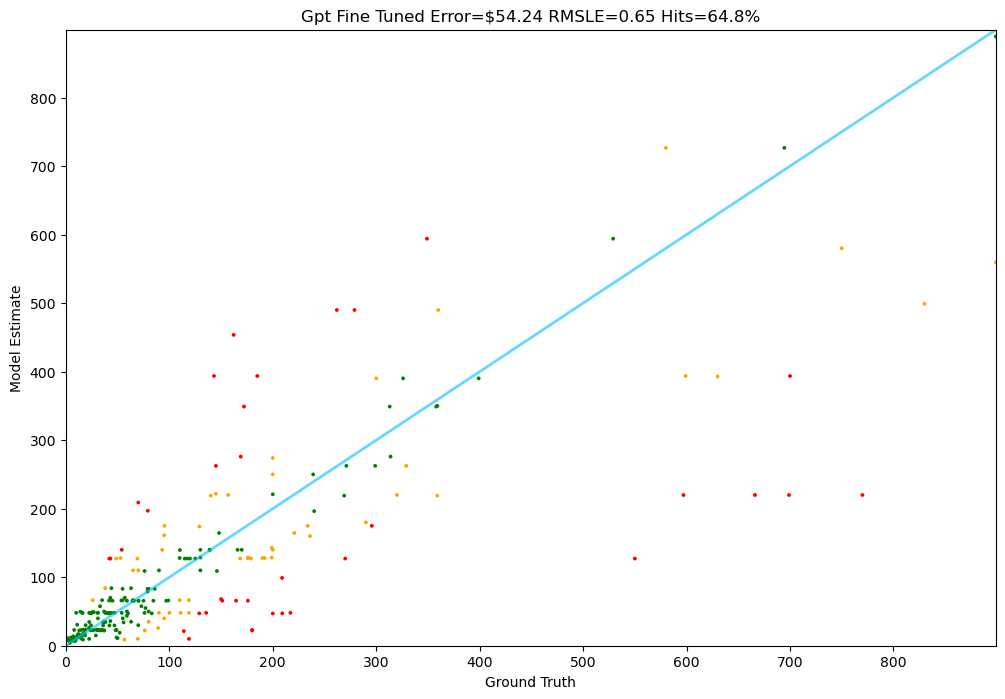

In [66]:
Tester.test(gpt_fine_tuned, test)